In [ ]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode
  Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py
'''
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

# Bi-LSTM(Attention) Parameters
embedding_dim = 2
n_hidden = 5 # number of hidden units in one cell
num_classes = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

inputs = []
for sen in sentences:
    inputs.append(np.asarray([word_dict[n] for n in sen.split()]))

targets = []
for out in labels:
    targets.append(out) # To using Torch Softmax Loss function

input_batch = Variable(torch.LongTensor(inputs))
target_batch = Variable(torch.LongTensor(targets))

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = Variable(torch.zeros(1*2, len(X), n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = Variable(torch.zeros(1*2, len(X), n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

model = BiLSTM_Attention()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5000):
    optimizer.zero_grad()
    output, attention = model(input_batch)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = Variable(torch.LongTensor(tests))

# Predict
predict, _ = model(test_batch)
predict = predict.data.max(1, keepdim=True)[1]
if predict[0][0] == 0:
    print(test_text,"is Bad Mean...")
else:
    print(test_text,"is Good Mean!!")
    

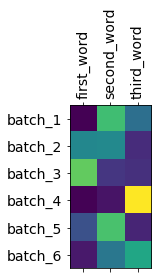

In [2]:
fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='viridis')
ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
plt.show()